- title: Занятие 14
- author: Sergey Korpachev
- date: 2024-12-02
- slug: 2024_lpr_lab14
- ipynb_url: download/2024_lpr_lab14.ipynb

Данный ноутбук основан на следующих источниках: [источник 1](https://github.com/hse-ds/ml-hse-nes/blob/main/2023/seminars/seminar11/sem11_pytorch.ipynb), [источник 2](https://stackoverflow.com/questions/74734100/what-is-the-architecture-of-a-scikit-learn-mlpregressor).

# Лабораторное занятие 14

В этом семинаре мы познакомимся с библиотекой **PyTorch**. Она очень похожа на **NumPy**, с одним лишь отличием (на самом деле их больше, но сейчас мы поговорим про самое главное) — **PyTorch** может считать градиенты за вас. Таким образом вам не надо будет руками писать обратный проход в нейросетях. Также вы научитесь создавать простые нейронные сети.

In [153]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision

from sklearn.datasets import fetch_california_housing
from torch import nn
from tqdm.notebook import tqdm

%matplotlib inline

### 1. Вспоминаем **NumPy** и сравниваем его функциональность с **PyTorch**

Мы можем создавать матрицы, перемножать их, складывать, транспонировать и в целом совершать любые матричные операции.

In [154]:
# случайная матрица
a = np.random.rand(5, 3)
a

array([[0.45964854, 0.94274848, 0.77684462],
       [0.59126898, 0.41120551, 0.29864937],
       [0.67420904, 0.47025157, 0.92347557],
       [0.1435711 , 0.53711224, 0.46070975],
       [0.37510001, 0.55882363, 0.47015417]])

In [155]:
# размеры массива
a.shape

(5, 3)

In [156]:
# сложение
a + 5

array([[5.45964854, 5.94274848, 5.77684462],
       [5.59126898, 5.41120551, 5.29864937],
       [5.67420904, 5.47025157, 5.92347557],
       [5.1435711 , 5.53711224, 5.46070975],
       [5.37510001, 5.55882363, 5.47015417]])

In [157]:
# матричное умножение
a @ a.T

array([[1.70353904, 0.89144344, 1.47062519, 0.93025389, 1.06448104],
       [0.89144344, 0.60788042, 0.86780433, 0.44334333, 0.5919876 ],
       [1.47062519, 0.86780433, 1.52850151, 0.77482901, 0.9498594 ],
       [0.93025389, 0.44334333, 0.77482901, 0.5213557 , 0.57060915],
       [1.06448104, 0.5919876 , 0.9498594 , 0.57060915, 0.67402881]])

In [158]:
# среднее по колонкам
a.mean(axis=-1)

array([0.72641388, 0.43370795, 0.68931206, 0.38046437, 0.46802594])

In [159]:
# решейп
a.reshape(3, 5).shape

(3, 5)

#### Разминка

При помощи **NumPy** посчитайте сумму квадратов натуральных чисел от 1 до 10000.

In [160]:
np.sum(np.arange(1, 10001, 1, dtype=np.int64)**2)

333383335000

Аналогичные операции в **PyTorch** очень похожи, но иногда имеют немного другой синтаксис

In [161]:
# случайный тензор
x = torch.rand(5, 3)
x

tensor([[0.7360, 0.3829, 0.1719],
        [0.7657, 0.1440, 0.0647],
        [0.0251, 0.8748, 0.3898],
        [0.3239, 0.0252, 0.9188],
        [0.0217, 0.4463, 0.8473]])

In [162]:
# размеры тензора
x.shape

torch.Size([5, 3])

In [163]:
# тоже размеры тензора
x.size()

torch.Size([5, 3])

In [164]:
# сложение
x + 5

tensor([[5.7360, 5.3829, 5.1719],
        [5.7657, 5.1440, 5.0647],
        [5.0251, 5.8748, 5.3898],
        [5.3239, 5.0252, 5.9188],
        [5.0217, 5.4463, 5.8473]])

In [165]:
# матричное умножение
# читайте документации по различным вариантам: @, torch.mm, torch.matmul, torch.bmm
torch.matmul(x, x.transpose(1, 0))

tensor([[0.7178, 0.6298, 0.4205, 0.4060, 0.3325],
        [0.6298, 0.6112, 0.1704, 0.3110, 0.1356],
        [0.4205, 0.1704, 0.9178, 0.3884, 0.7213],
        [0.4060, 0.3110, 0.3884, 0.9498, 0.7968],
        [0.3325, 0.1356, 0.7213, 0.7968, 0.9176]])

In [166]:
# очередное матричное умножение
x.mm(x.t())

tensor([[0.7178, 0.6298, 0.4205, 0.4060, 0.3325],
        [0.6298, 0.6112, 0.1704, 0.3110, 0.1356],
        [0.4205, 0.1704, 0.9178, 0.3884, 0.7213],
        [0.4060, 0.3110, 0.3884, 0.9498, 0.7968],
        [0.3325, 0.1356, 0.7213, 0.7968, 0.9176]])

In [167]:
# поэлементное умножение
x * x

tensor([[5.4166e-01, 1.4658e-01, 2.9560e-02],
        [5.8625e-01, 2.0727e-02, 4.1847e-03],
        [6.3232e-04, 7.6524e-01, 1.5197e-01],
        [1.0488e-01, 6.3362e-04, 8.4426e-01],
        [4.6898e-04, 1.9916e-01, 7.1798e-01]])

In [168]:
# среднее по колонкам
x.mean(dim=-1)

tensor([0.4303, 0.3248, 0.4299, 0.4226, 0.4384])

In [169]:
# решейп
x.view([3, 5]).shape

torch.Size([3, 5])

In [170]:
# или так
x.reshape([3, 5]).shape

torch.Size([3, 5])

In [171]:
# будьте внимательны и не используйте view для транспонирования осей!
x.view_as(x.t()) == x.t()

tensor([[ True, False, False, False, False],
        [False, False,  True, False, False],
        [False, False, False, False,  True]])

Небольшой пример того, как меняются операции:

* `x.reshape([1,2,8]) -> x.view(1,2,8)`

* `x.sum(axis=-1) -> x.sum(dim=-1)`

* `x.astype("int64") -> x.type(torch.LongTensor)`

Для помощи вам есть [таблица](https://github.com/torch/torch7/wiki/Torch-for-Numpy-users), которая поможет вам найти аналог **NumPy** операции в **PyTorch**


#### Разминка на pytorch

При помощи pytorch посчитайте сумму квадратов натуральных чисел от 1 до 10000.

In [172]:
(torch.arange(1, 10001, 1)**2).sum().type(torch.LongTensor)

tensor(333383335000)

### 2. Создаем тензоры в **PyTorch** и изучаем больше базовых операций

In [173]:
# пустой тензор
x = torch.empty(5, 3)
x

tensor([[0.0000, 0.0000, 0.2479],
        [0.4532, 0.0593, 0.7929],
        [0.0851, 0.7084, 0.5206],
        [1.2159, 1.4663, 0.9323],
        [0.4479, 0.3966, 0.2775]])

In [174]:
# случайный тензор ~ Uniform[0, 1)
x = torch.rand(5, 3)
x

tensor([[0.2095, 0.7438, 0.1058],
        [0.8019, 0.9696, 0.9210],
        [0.8926, 0.5711, 0.8259],
        [0.7351, 0.6030, 0.9373],
        [0.2085, 0.9656, 0.2706]])

In [175]:
# тензор с нулями и указанием типов чисел
x = torch.zeros(5, 3, dtype=torch.float32)
x

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [176]:
# конструируем тензор из питоновского листа
x = torch.tensor([5.5, 3])
x

tensor([5.5000, 3.0000])

In [177]:
# используем уже созданный тензор для создания тензора из единичек
x1 = x.new_ones(5, 3, dtype=torch.double)
x1

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)

In [178]:
# создаем случайный тензор с размерами другого тензора
x = torch.randn_like(x1, dtype=torch.float)
x

tensor([[-1.2136, -0.3726,  1.2620],
        [-1.6297, -0.0516, -0.0432],
        [-0.5856, -0.9094,  1.3928],
        [ 0.0791,  1.8197,  1.1493],
        [ 0.2611, -0.7999,  1.7705]])

In [179]:
x = torch.rand(5, 3)
y = torch.rand(5, 3)

In [180]:
x

tensor([[0.4796, 0.4597, 0.7056],
        [0.6085, 0.4234, 0.1215],
        [0.1365, 0.3791, 0.6607],
        [0.5581, 0.1132, 0.3746],
        [0.0191, 0.7007, 0.5954]])

In [181]:
y

tensor([[0.5269, 0.0291, 0.9861],
        [0.2542, 0.1346, 0.2079],
        [0.1603, 0.5500, 0.7397],
        [0.3433, 0.0346, 0.5821],
        [0.2732, 0.5290, 0.6871]])

In [182]:
# сложение
x + y

tensor([[1.0065, 0.4888, 1.6916],
        [0.8627, 0.5581, 0.3294],
        [0.2968, 0.9292, 1.4004],
        [0.9014, 0.1478, 0.9567],
        [0.2922, 1.2297, 1.2826]])

In [183]:
# очередное сложение
z = torch.add(x, y)
z

tensor([[1.0065, 0.4888, 1.6916],
        [0.8627, 0.5581, 0.3294],
        [0.2968, 0.9292, 1.4004],
        [0.9014, 0.1478, 0.9567],
        [0.2922, 1.2297, 1.2826]])

In [184]:
# наконец, ещё одно сложение!
torch.add(x, y, out=x)
x

tensor([[1.0065, 0.4888, 1.6916],
        [0.8627, 0.5581, 0.3294],
        [0.2968, 0.9292, 1.4004],
        [0.9014, 0.1478, 0.9567],
        [0.2922, 1.2297, 1.2826]])

In [185]:
# добавили измерение в начало, аналог броадкастинга
x.unsqueeze(0).size()

torch.Size([1, 5, 3])

In [186]:
# убрали одно единичное измерение
x.unsqueeze(0).unsqueeze(1).squeeze(0).size()

torch.Size([1, 5, 3])

In [187]:
# убрали все единичные измерения
x.unsqueeze(0).unsqueeze(1).squeeze().size()

torch.Size([5, 3])

In [188]:
# операции без _ не меняют тензор, а создают копию
x.unsqueeze(0)
x.size()

torch.Size([5, 3])

In [189]:
# операции с _ меняют тензор
x.unsqueeze_(0)
x.size()

torch.Size([1, 5, 3])

Мы можем делать обычные срезы и переводить матрицы из **PyTorch** в **NumPy** и наоборот:

In [190]:
a = np.ones((3, 5))
x = torch.ones((3, 5))
np.allclose(x.numpy(), a)

True

In [191]:
np.allclose(x[:, 1], a[:, 1])

True

In [192]:
np.allclose(x.numpy()[:, 1], a[:, 1])

True

In [193]:
torch.from_numpy(x.numpy())

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

<a name="cell-id"></a>
### 3. Работаем с градиентами руками

[California](https://inria.github.io/scikit-learn-mooc/python_scripts/datasets_california_housing.html)

X: MedInc (median income in block group).

y: the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

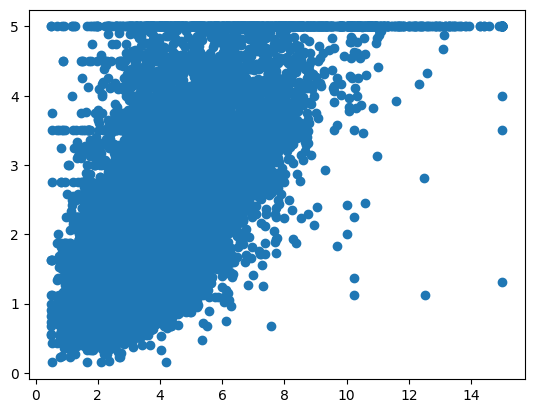

In [194]:
housing = fetch_california_housing()
plt.scatter(housing.data[:, 0], housing.target);

В **PyTorch** есть возможность при создании тензора указывать нужно ли считать по нему градиент или нет, с помощью параметра `requires_grad`. Когда `requires_grad=True` мы сообщаем фреймворку, о том, что мы хотим следить за всеми тензорами, которые получаются из созданного. Иными словами, у любого тензора, у которого указан данный параметр, будет доступ к цепочке операций и преобразований совершенными с ними. Если эти функции дифференцируемые, то у тензора появляется параметр `.grad`, в котором хранится значение градиента.

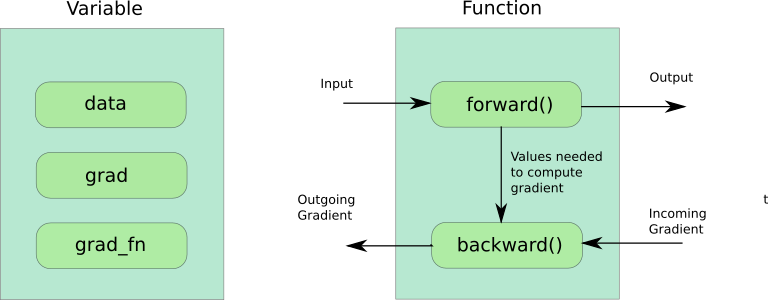

Если к результирующему тензору применить метод `.backward()`, то фреймворк посчитает по цепочке градиенты для всех тензоров, у которых `requires_grad=True`.

In [195]:
w = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)

x = torch.tensor(housing.data[:, 0] / housing.data[:, 0].max(), dtype=torch.float32)
y = torch.tensor(housing.target, dtype=torch.float32)

# только создали тензоры и в них нет градиентов
assert w.grad is None
assert b.grad is None

In [196]:
x.size(), y.size()

(torch.Size([20640]), torch.Size([20640]))

In [197]:
y_pred = w * x + b
loss = torch.mean((y_pred - y) ** 2)
loss.backward() 

In [198]:
# сделали операции и посчитали градиенты, появилось значение соответствующих полей
assert w.grad is not None
assert b.grad is not None

print(f"dL/dw = {w.grad}")
print(f"dL/db = {b.grad}")

dL/dw = tensor([-1.0711])
dL/db = tensor([-3.4233])


Для доступа к значениям в тензоре используйте атрибут `.data`:

In [199]:
w.data, w.grad

(tensor([0.4170]), tensor([-1.0711]))

In [200]:
w

tensor([0.4170], requires_grad=True)

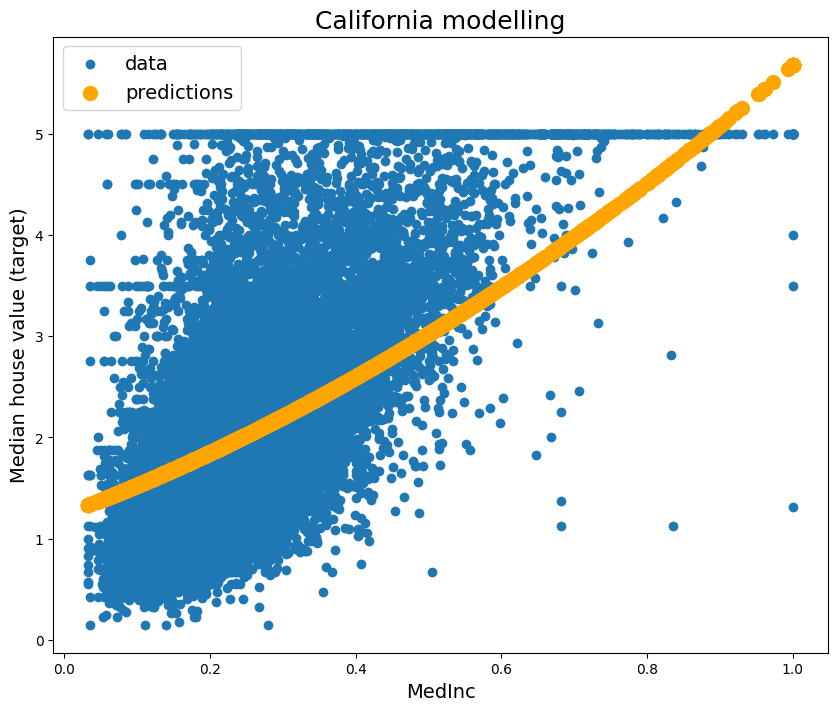

loss =  0.799013
Done!


In [201]:
from IPython.display import clear_output
w1 = torch.rand(1, requires_grad=True)
w2 = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)
for i in range(500):
    y_pred = w1 * x + w2 * x**2 + b
    # попробуйте сделать полиномиальную регрессию в данном предсказании и посчитать градиенты после
    loss = torch.mean((y_pred - y) ** 2)
    loss.backward()

    # делаем шаг градиентного спуска с lr = .05
    w1.data -= 0.05 * w1.grad
    w2.data -= 0.05 * w2.grad
    b.data -= 0.05 * b.grad

    # обнуляем градиенты, чтобы на следующем шаге опять посчитать и не аккумулировать их
    w1.grad.data.zero_()
    w2.grad.data.zero_()
    b.grad.data.zero_()

    # рисуем картинки
    if (i + 1) % 10 == 0:
        clear_output(True)
        plt.figure(figsize=(10,8))
        plt.scatter(x.data.numpy(), y.data.numpy(), label="data")
        plt.scatter(x.data.numpy(), y_pred.data.numpy(),
                    color="orange", linewidth=5, label="predictions")
        plt.xlabel("MedInc", fontsize=14)
        plt.ylabel("Median house value (target)", fontsize=14)
        plt.title("California modelling", fontsize=18)
        plt.legend(fontsize=14)
        plt.show()

        print("loss = ", loss.data.numpy())
        if loss.data.numpy() < 0.8:
            print("Done!")
            break


Как вам результат? Можно ли его как-то улучшить?

### 4. Моя первая нейросеть

Для того, чтобы разобраться как обучать нейросети в **PyTorch**, нужно освоить три вещи:

1. Как формировать батчи и подавать их на вход сети
2. Как задать архитектуру сети
3. Как написать цикл обучения и отслеживать метрики

#### Как формировать батчи и подавать их на вход нейросети

Чтобы иметь возможность итерироваться по данным и применять к ним преобразования (например, аугментации, о которых вы узнаете позже), нужно создать свой класс унаследованный от `torch.utils.data.Dataset`.

У такого класса **должно быть** три метода:

* `__init__` — создаёт поля класса (например, путь к папке с файлами с тренировочными объектами)
* `__len__` — возвращает информацию о том, сколько объектов у нас в датасете
* `__getitem__` — по индексу возвращает семпл и таргет к нему


Давайте напишем такой сами, в качестве данных используя рандомные значения.

In [202]:
class RandomDataset(torch.utils.data.Dataset):
    """
    Our random dataset
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return {"sample": torch.tensor(self.x[idx, :], dtype=torch.float), "target": self.y[idx]}

In [203]:
x = np.random.rand(1000, 5)
y = np.random.rand(1000)

In [204]:
our_dataset = RandomDataset(x, y)

In [205]:
our_dataset.__getitem__(1)

{'sample': tensor([0.3933, 0.7100, 0.9215, 0.4937, 0.7015]),
 'target': 0.6817036477521301}

Для того, чтобы из данных получать батчи в pytorch используется такая сущность как даталоадер, который принимает на вход класс унаследованный от `torch.utils.data.Dataset`. Сейчас посмотрим на пример:

In [206]:
dataloader = torch.utils.data.DataLoader(our_dataset, batch_size=4)

Работают с ним следующим образом:

In [207]:
batch = next(iter(dataloader))

print(f"Sample:\n{batch['sample']}")
print(f"Target:\n{batch['target']}")

Sample:
tensor([[0.6525, 0.8242, 0.4108, 0.5970, 0.5530],
        [0.3933, 0.7100, 0.9215, 0.4937, 0.7015],
        [0.2805, 0.4921, 0.1538, 0.1406, 0.2500],
        [0.7871, 0.5206, 0.3078, 0.9182, 0.0669]])
Target:
tensor([0.6251, 0.6817, 0.0086, 0.2919], dtype=torch.float64)


#### Как сделать нейросеть

Для того, чтобы в high-level **PyTorch** создавать нейросети, используется модуль `torch.nn`. Нейросеть должна быть унаследована от класса `nn.Module`. Пример как это может выглядеть:

```python
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 20, 5)

    def forward(self, x):
       x = F.relu(self.conv1(x))
       return F.relu(self.conv2(x))
```

Как мы видим на данном примере, у данного класса **должен быть** метод `forward`, который определяет прямой проход нейросети. Также из класса выше видно, что модуль `nn` содержит в себе реализацию большинства слоев, а модуль `nn.functional` -- функций активаций.

Есть еще один способ создать нейросеть и давайте его разберем на практике:

In [208]:
model = nn.Sequential()                   # создаем пустую модель, в которую будем добавлять слои
model.add_module("l1", nn.Linear(5, 30))  # добавили слой с 5-ю нейронами на вход и 3-мя на выход
model.add_module("l2", nn.ReLU())         # добавили функцию активации
model.add_module("l3", nn.Linear(30, 1))  # добавили слой с 3-мя нейронами на вход и 5-ю на выход

# альтернативный способ
another_model = nn.Sequential(
    nn.Linear(5, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

In [209]:
y_pred = model(batch['sample'])  # получили предсказания модели

#### Как написать цикл обучения и отслеживать метрики

Давайте теперь соберем теперь загрузку данных, создание модели и обучим на уже созданном для нас датасете MNIST

In [210]:
# используем готовый класс от торча для загрузки данных для тренировки
mnist_train = torchvision.datasets.MNIST(
    "./mnist/",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
mnist_val = torchvision.datasets.MNIST(
    "./mnist/",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

# так как это уже унаследованный от Dataset класс, его можно сразу обернуть в даталоадер
train_dataloader = torch.utils.data.DataLoader(
    mnist_train,
    batch_size=4,
    shuffle=True,
    num_workers=1
)

val_dataloader = torch.utils.data.DataLoader(
    mnist_val,
    batch_size=4,
    shuffle=False,
    num_workers=1
)

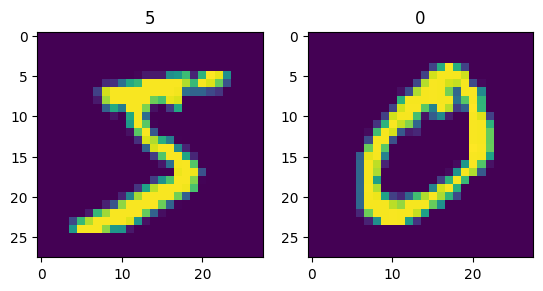

In [211]:
# посмотрим на то, с чем мы работаем
for i in [0, 1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(mnist_train[i][0].squeeze(0).numpy().reshape([28, 28]))
    plt.title(str(mnist_train[i][1]))
plt.show()

In [212]:
model = nn.Sequential(
    nn.Flatten(),             # превращаем картинку 28х28 в вектор размером 784
    nn.Linear(28 * 28, 128),  # линейный слой, преобразующий вектор размера 784 в вектор размера 128
    nn.ReLU(),                # нелинейность
    nn.Linear(128, 10),       # линейный слой, преобразующий вектор размера 128 в вектор размера 10
)

# создаем оптимизатор, который будет обновлять веса модели
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

Веса моделей хранятся в виде матриц и выглядят так:

In [213]:
[x for x in model.named_parameters()]

[('1.weight',
  Parameter containing:
  tensor([[-0.0130, -0.0248,  0.0251,  ...,  0.0301, -0.0142,  0.0026],
          [ 0.0069, -0.0315,  0.0322,  ...,  0.0048,  0.0259, -0.0097],
          [ 0.0146, -0.0133, -0.0125,  ..., -0.0116, -0.0302,  0.0201],
          ...,
          [ 0.0223, -0.0094, -0.0351,  ..., -0.0136, -0.0113,  0.0020],
          [-0.0156, -0.0097,  0.0159,  ..., -0.0308,  0.0264,  0.0108],
          [-0.0045,  0.0046,  0.0263,  ...,  0.0350, -0.0189, -0.0017]],
         requires_grad=True)),
 ('1.bias',
  Parameter containing:
  tensor([-2.1649e-02,  1.3876e-02,  1.8678e-02, -1.8136e-02,  3.0350e-02,
          -7.2295e-03, -3.3093e-02, -2.5581e-02, -1.2193e-03,  1.6890e-02,
           3.1580e-02,  2.7896e-02,  2.8706e-02, -4.3716e-05,  2.2012e-03,
           1.3217e-02, -6.6047e-03, -1.9434e-02, -1.1341e-02, -3.9778e-03,
           2.4435e-03, -2.3395e-02,  7.2749e-03, -1.3064e-02, -3.2248e-02,
          -6.8471e-03,  2.1374e-02, -6.8711e-03, -1.6254e-03,  7.2595e-0

Запустим процесс обучения (код может выполняться чуть больше 5 минут):

In [214]:
# всего у нас будет 5 эпох (5 раз подряд пройдемся по всем батчам из трейна)
train_losses = []
val_losses = []
for epoch in range(5):
    train_loss = []
    for x_train, y_train in tqdm(train_dataloader):    # берем батч из трейн лоадера
        y_pred = model(x_train)                        # делаем предсказания
        loss = F.cross_entropy(y_pred, y_train)        # считаем лосс
        with torch.no_grad():      
            train_loss.append(loss.numpy())
        loss.backward()                                # считаем градиенты обратным проходом
        optimizer.step()                               # обновляем параметры сети
        optimizer.zero_grad()                          # обнуляем посчитанные градиенты параметров

    train_losses.append(np.mean(train_loss))
    val_loss = []                                  # сюда будем складывать **средний по бачу** лосс
    val_accuracy = []
    with torch.no_grad():                          # на валидации запрещаем фреймворку считать градиенты по параметрам
        for x_val, y_val in tqdm(val_dataloader):  # берем батч из валидационного лоадера
            y_pred = model(x_val)                  # делаем предсказания
            loss = F.cross_entropy(y_pred, y_val)  # считаем лосс
            val_loss.append(loss.numpy())          # добавляем в массив
            val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
    val_losses.append(np.mean(val_loss))
    # печатаем метрики
    print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}")

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 0, loss: 0.11321381479501724, accuracy: 0.9638


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 1, loss: 0.0958307608962059, accuracy: 0.9721


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 2, loss: 0.08521059900522232, accuracy: 0.9742


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 3, loss: 0.08691907674074173, accuracy: 0.9729


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

Epoch: 4, loss: 0.09864281862974167, accuracy: 0.9718


#### Задания

**Задание 1**. Нарисуйте кривые лоссов для трейна и валидации. Для этого может потребоваться изменение кода выше.

По кривым можно что-то сказать?

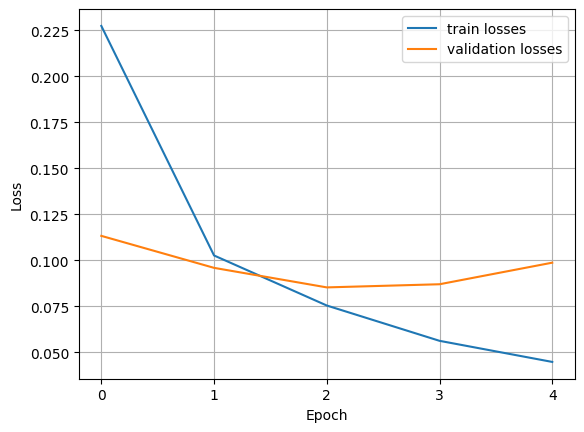

In [215]:
plt.plot([0, 1, 2, 3, 4], train_losses, label="train losses")
plt.plot([0, 1, 2, 3, 4], val_losses, label="validation losses")
plt.xticks([0, 1, 2, 3, 4])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(visible=True)
plt.legend();

In [ ]:
# Один раз прогнал, он сказал, что после второй эпохи вал_лос начал увеличиваться. Потом наоборот наоборот. Потом снова.
# Но отклонения вроде незначительные, вроде не переобучается сильно. трэин_лос уменьшается, что и ожидалось

**Задание 2**. В третьем разделе ([3. Работаем с градиентами руками](#cell-id)) данного ноутбука вы разбирали датасет California. Сделайте тоже самое, но для датасета boston. Для вас уже подготовлен код для загрузки данных.

Какие можно сделать выводы по новому датасету?

In [217]:
import pandas as pd

In [218]:
# `load_boston` has been removed from scikit-learn since version 1.2.

#from sklearn.datasets import load_boston
#boston = load_boston()
#print(boston["DESCR"])

#X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
#y = boston["target"]

In [219]:
df = pd.read_csv('data/boston_house_prices.csv' )
df.columns = df.loc[0]
df = df.drop(0, axis=0)
df = df.reset_index().drop("index", axis=1)
df = df.astype(np.float64)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


**Data Set Characteristics:**  

```doc
    :Number of Instances: 506

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
.. topic:: References

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.
```

In [234]:
from sklearn.preprocessing import StandardScaler
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

X = df[feature_names]
y = df["MEDV"]
scaler = StandardScaler()
X[feature_names] = scaler.fit_transform(X, y)

<Axes: xlabel='0', ylabel='0'>

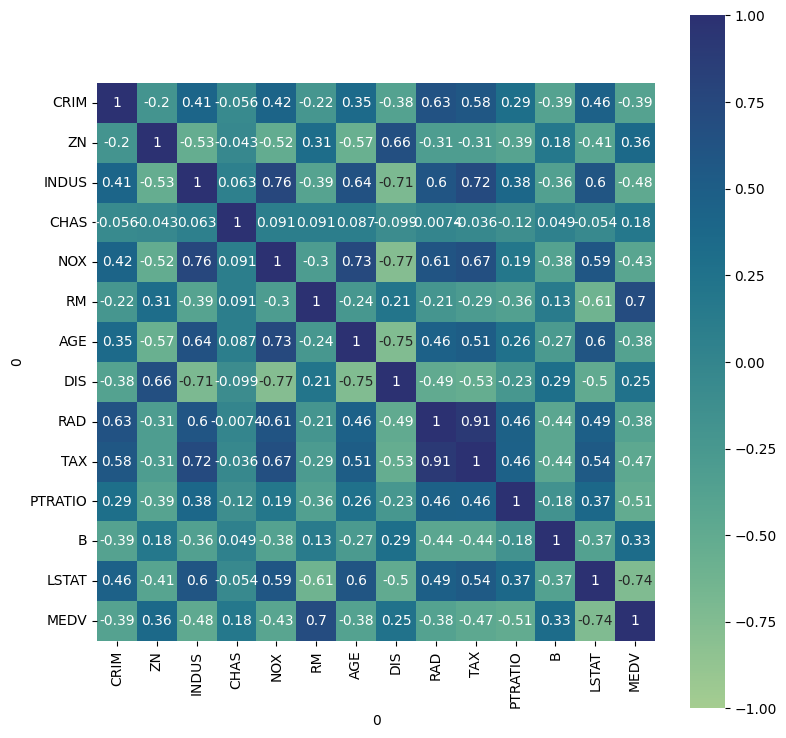

In [235]:
import seaborn as sns

plt.figure(figsize=(9, 9))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, square=True, cmap="crest")

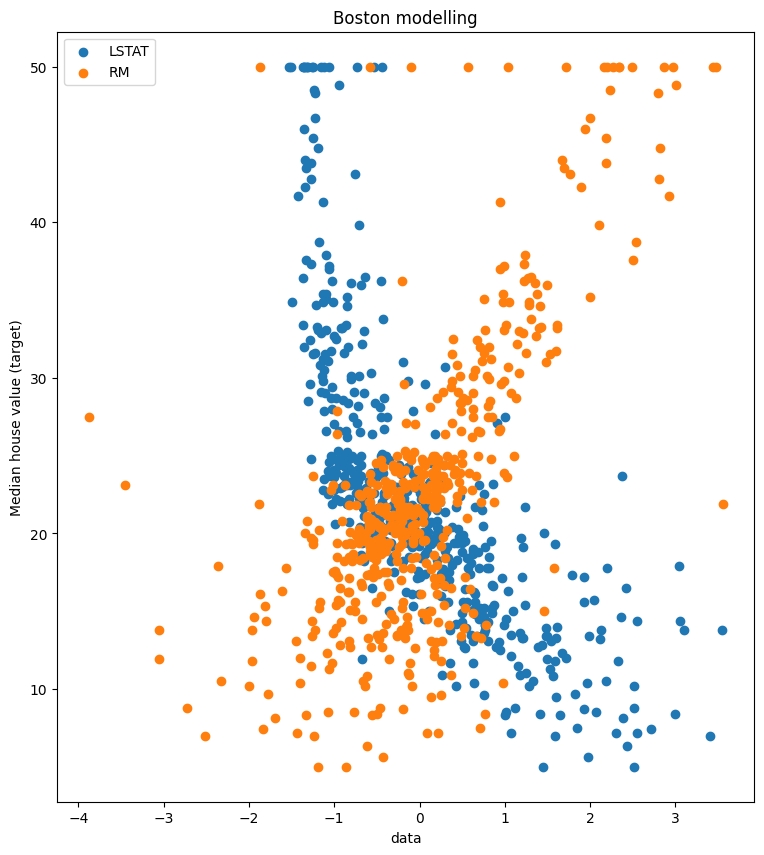

In [277]:
# Как видно, LSTAT и RM хорошо коррелируют с MEDV
x1 = torch.tensor(X["LSTAT"], dtype=torch.float32)
x2 = torch.tensor(X["RM"], dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
plt.figure(figsize=(9, 10))
plt.scatter(x1.data.numpy(), y.data.numpy(), label="LSTAT")
plt.scatter(x2.data.numpy(), y.data.numpy(), label="RM")
plt.xlabel("data")
plt.ylabel("Median house value (target)")
plt.title("Boston modelling")
plt.legend()
plt.show()

In [278]:
# На мой взгляд, RM аппроксимируется прямой, а для LSTAT подойдет экспонента 

In [279]:
w1 = torch.rand(1, requires_grad=True)
w2 = torch.rand(1, requires_grad=True)
w3 = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)
for i in range(300):
    y_pred = w1 * x1 + w2 * x1**2 + w3 * x2 + b
    loss = torch.mean((y_pred - y) ** 2)
    loss.backward()

    w1.data -= 0.05 * w1.grad
    w2.data -= 0.05 * w2.grad
    w3.data -= 0.05 * w3.grad
    b.data -= 0.05 * b.grad

    w1.grad.data.zero_()
    w2.grad.data.zero_()
    w3.grad.data.zero_()
    b.grad.data.zero_()
print("loss = ", loss.data.numpy())

loss =  25.066677


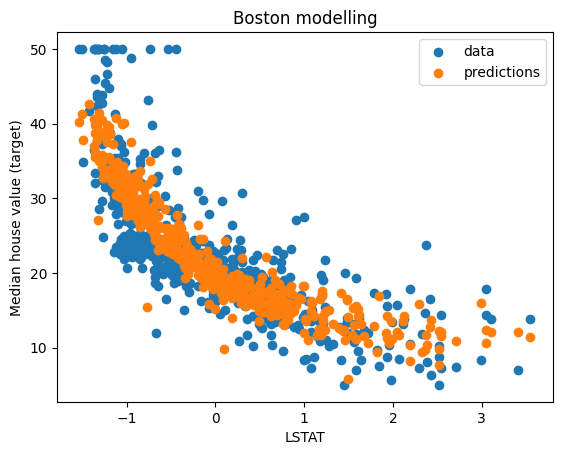

In [280]:
plt.scatter(x1.data.numpy(), y.data.numpy(), label="data")
plt.scatter(x1.data.numpy(), y_pred.data.numpy(), label="predictions")
plt.xlabel("LSTAT")
plt.ylabel("Median house value (target)")
plt.title("Boston modelling")
plt.legend()
plt.show()


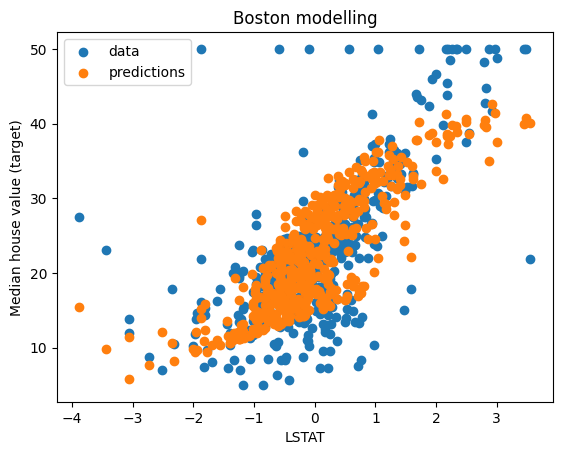

In [281]:
plt.scatter(x2.data.numpy(), y.data.numpy(), label="data")
plt.scatter(x2.data.numpy(), y_pred.data.numpy(), label="predictions")
plt.xlabel("LSTAT")
plt.ylabel("Median house value (target)")
plt.title("Boston modelling")
plt.legend()
plt.show()

### Дополнительная практика

Создавать нейронные сети можно не только в **PyTorch**. Также существуют другие библиотеки для разработки нейронных сетей: [Keras](https://keras.io), [TensorFlow](https://github.com/tensorflow/tensorflow), [JAX](https://jax.readthedocs.io/en/latest/) и так далее. Это самые основные.

Но давайте вспомним sklearn, там тоже можно делать весьма неплохие нейросетевые модели.

Импортируем многослойный перцептрон для задачи регрессии ([MLPRegressor](https://scikit-learn.org/dev/modules/generated/sklearn.neural_network.MLPRegressor.html)) и [make_regression](https://scikit-learn.org/dev/modules/generated/sklearn.datasets.make_regression.html) из sklearn. И посмотрим, как это будет работать.

In [282]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

import warnings
warnings.filterwarnings('ignore')

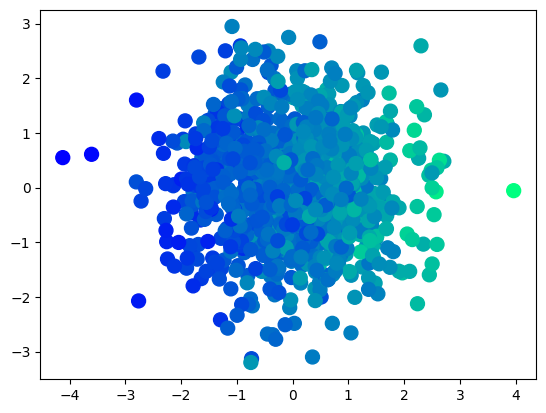

In [283]:
X, y = make_regression(n_samples=1000, n_features=6)

plt.scatter(X[:, 0], X[:, 1], s=100, c=y, cmap="winter")
plt.show()

In [284]:
nn = MLPRegressor(hidden_layer_sizes=(100, 20), activation="relu",
                 solver='adam', alpha=0.0001,
                 batch_size='auto', learning_rate="constant",
                 learning_rate_init=0.001,
                 max_iter=1000,tol=1e-4)

In [285]:
nn.fit(X, y)

MLPRegressor(hidden_layer_sizes=(100, 20), max_iter=1000)

Можно вывести архитектуру нашей сети:

In [286]:
print(f"Number of inputs:  {nn.n_features_in_}")
print(f"Number of outputs: {nn.n_outputs_}")
print(f"Number of layers:  {nn.n_layers_}")
print(f"Layer sizes: {[l.shape for l in nn.coefs_]}")

Number of inputs:  6
Number of outputs: 1
Number of layers:  4
Layer sizes: [(6, 100), (100, 20), (20, 1)]


### Дополнительные материалы:

* [Хорошая книга про pytorch](https://github.com/borninfreedom/DeepLearning/blob/master/Books/Deep-Learning-with-PyTorch.pdf)
* [Использование pytorch на GPU](https://pytorch.org/docs/master/notes/cuda.html)
* [Pytorch за 60 минут](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* [Как устроено автоматическое дифференцирование в pytorch](https://www.cs.toronto.edu/~duvenaud/talks/Johnson-Automatic-Differentiation.pdf)